# Gaussian Distribution using GAN
### Generator:                  
Input: 10 random noises         
Output: 500 fake samples (that look like they were sampled from the Gaussian distribution)             
### Discriminator:                     
Input: 500 samples                   
Output: it should tell us whether the samples are from real or fake data.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# params for the distribution
mean = 5.0 
sd = 1.0

(array([ 4.,  1.,  1.,  7.,  8., 23., 22., 45., 54., 49., 56., 48., 58.,
        51., 33., 20.,  7.,  8.,  3.,  2.]),
 array([1.84246481, 2.14201651, 2.44156821, 2.74111991, 3.04067161,
        3.34022331, 3.63977502, 3.93932672, 4.23887842, 4.53843012,
        4.83798182, 5.13753352, 5.43708522, 5.73663692, 6.03618863,
        6.33574033, 6.63529203, 6.93484373, 7.23439543, 7.53394713,
        7.83349883]),
 <a list of 20 Patch objects>)

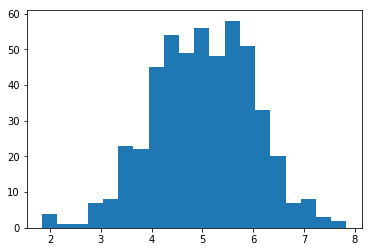

In [4]:
# sample gaussian disrtibution 
#np.random.normal  draws random samples from a normal (Gaussian) distribution
sample_size = 500
test_samples = np.random.normal(mean, sd, sample_size)
plt.hist(test_samples, bins=20)

In [5]:
# Input noise for generator 
torch.rand(1)

tensor([0.3294])

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.dense1(x) 
        x = self.activation_function(x)
        x = self.dense2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        self.activation_function = nn.Sigmoid()

    def forward(self, x):
        x = self.dense1(x) 
        x = self.activation_function(x)
        x = self.dense2(x)
        x = self.activation_function(x)
        return x

In [7]:
#hyperpara
lr_d = 1e-04
lr_g = 1e-04
g_input_dim = 10 
g_hidden_dim = 128
d_hidden_dim = 64
sample_size = 500

train_iter = 10000
d_steps = 10
g_steps = 2

In [8]:
G = Generator(input_dim = g_input_dim,
              hidden_dim = g_hidden_dim,
              output_dim = sample_size).to(device)

D = Discriminator(input_dim = sample_size,
              hidden_dim = d_hidden_dim,
              output_dim = 1).to(device)

criterion = nn.BCELoss().to(device)
optimizer_d = optim.Adam(D.parameters(), lr=lr_d)
optimizer_g = optim.Adam(G.parameters(), lr=lr_g)

In [9]:
save_dist = []
for i in range(train_iter):
    if i % 100 == 0:
        with torch.no_grad():
            noise = torch.rand(g_input_dim).to(device)
            gen_dist = G(noise).cpu().detach().numpy()
            save_dist.append(gen_dist)
        
    for d_step in range(d_steps):
        D.zero_grad()
        #Sample minibatch of m noise samples from noise prior p_g(z).
        noise = torch.rand(g_input_dim).to(device)
        p_g = G(noise)
        d_gen_out = D(p_g) 
        #Sample  minibatch  of m examples from  data  generating  distribution pdata(x)
        p_data = torch.Tensor(np.random.normal(mean, sd, sample_size)).to(device)
        d_real_out = D(p_data) 
        #Update the discriminator by ascending its gradient
        d_gen_loss = criterion(d_gen_out, torch.zeros([1]).to(device)) 
        d_gen_loss.backward()
        d_real_loss = criterion(d_real_out, torch.ones([1]).to(device)) 
        d_real_loss.backward()
        optimizer_d.step()
        
        #print(d_gen_loss,d_real_loss)
    for g_step in range(g_steps):     
        G.zero_grad()
        #Sample minibatch of m noise samples from noise prior pg(z).
        noise = torch.rand(g_input_dim).to(device)
        g_loss = criterion(D(G(noise)) , torch.ones([1]).to(device)) 
        g_loss.backward()
        #Update the generator by descending its gradient
        optimizer_g.step()
    


# let's see whether it works
you can see that generator can produce distribution closer and closer to the real distribution (mean=5.0, sd=1.0), as  the iteration increases. 

(array([ 3.,  3.,  8., 18., 20., 32., 47., 53., 54., 65., 63., 35., 37.,
        32., 12.,  9.,  0.,  4.,  3.,  2.]),
 array([-0.45284662, -0.40307835, -0.3533101 , -0.30354184, -0.25377357,
        -0.20400533, -0.15423706, -0.10446881, -0.05470055, -0.00493229,
         0.04483597,  0.09460423,  0.1443725 ,  0.19414075,  0.243909  ,
         0.29367727,  0.3434455 ,  0.39321378,  0.44298205,  0.4927503 ,
         0.54251856], dtype=float32),
 <a list of 20 Patch objects>)

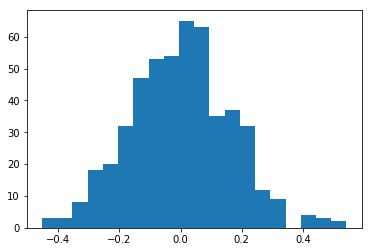

In [11]:
plt.hist(save_dist[0], bins = 20)

(array([ 4., 10., 29., 41., 39., 37., 31., 23., 32., 25., 23., 20., 23.,
        27., 33., 46., 34., 16.,  5.,  2.]),
 array([-0.3314335 , -0.25346997, -0.17550646, -0.09754293, -0.01957941,
         0.05838411,  0.13634764,  0.21431115,  0.29227468,  0.3702382 ,
         0.44820172,  0.52616525,  0.6041288 ,  0.6820923 ,  0.76005584,
         0.8380194 ,  0.91598284,  0.9939464 ,  1.0719099 ,  1.1498735 ,
         1.227837  ], dtype=float32),
 <a list of 20 Patch objects>)

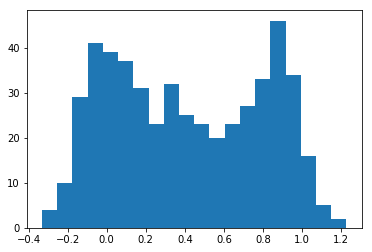

In [12]:
plt.hist(save_dist[5], bins = 20)

(array([ 4., 12., 25., 34., 44., 37., 31., 18., 28., 24., 21., 36., 26.,
        21., 25., 27., 40., 28., 10.,  9.]),
 array([-0.37967882, -0.24522398, -0.11076916,  0.02368567,  0.1581405 ,
         0.29259533,  0.42705014,  0.56150496,  0.6959598 ,  0.83041465,
         0.96486944,  1.0993242 ,  1.2337791 ,  1.3682339 ,  1.5026888 ,
         1.6371436 ,  1.7715985 ,  1.9060532 ,  2.040508  ,  2.174963  ,
         2.3094177 ], dtype=float32),
 <a list of 20 Patch objects>)

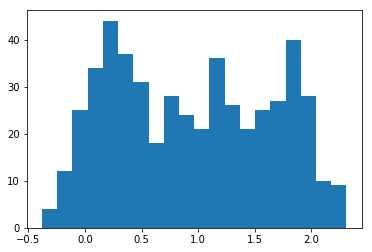

In [15]:
plt.hist(save_dist[10], bins = 20)

(array([ 4.,  6., 13., 15., 23., 44., 54., 67., 60., 58., 58., 41., 27.,
        15.,  8.,  2.,  2.,  2.,  0.,  1.]),
 array([3.896252 , 4.005532 , 4.1148114, 4.224091 , 4.333371 , 4.442651 ,
        4.5519304, 4.6612105, 4.77049  , 4.87977  , 4.98905  , 5.0983295,
        5.207609 , 5.3168893, 5.426169 , 5.5354486, 5.6447287, 5.7540083,
        5.863288 , 5.972568 , 6.0818477], dtype=float32),
 <a list of 20 Patch objects>)

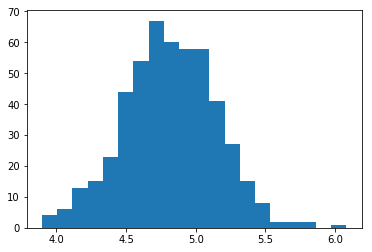

In [14]:
plt.hist(save_dist[-1], bins = 20)

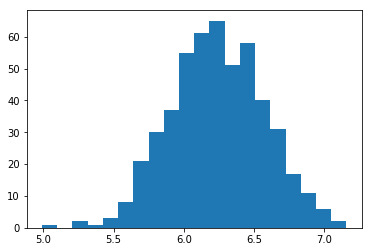

In [10]:
with torch.no_grad():
    noise = torch.Tensor(np.random.uniform(0,1,10)).to(device)
    gen_dist = G(noise).cpu().detach().numpy()
    plt.hist(gen_dist, bins = 20)